# Setup Enviorment

In [1]:
import os
import shutil

import matplotlib.pyplot as plt

from skimage import io
from skimage.transform import resize

from sklearn.model_selection import train_test_split

import numpy as np
import tensorflow as tf

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Main Directory
path = 'Dataset/'

### See an example of the data

In [4]:
bands = [1,2,3]

import matplotlib.pyplot as plt
def show_image(bands, image, size=6):
    print(f'The shape of the image is: {image.shape}')
    plt.figure(figsize=(size, size))
    plt.imshow(image[:,:,bands])
    plt.show()

---------- Cali ----------
The city has 165 images
The shape of the image is: (745, 748, 12)


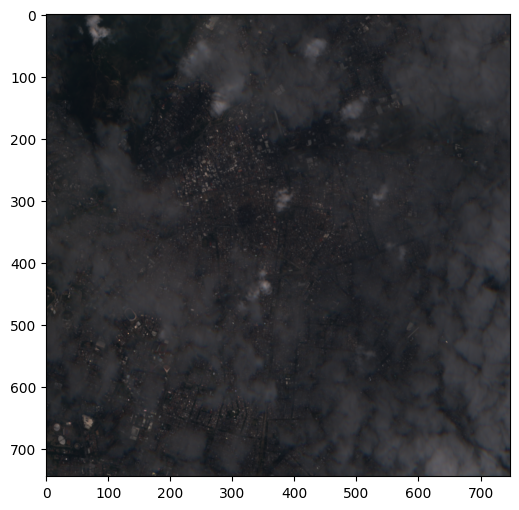

---------- Cúcuta ----------
The city has 165 images
The shape of the image is: (751, 742, 12)


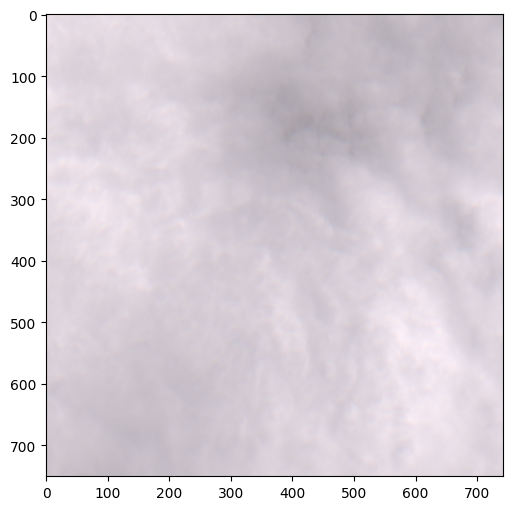

---------- Villavicencio ----------
The city has 165 images
The shape of the image is: (747, 745, 12)


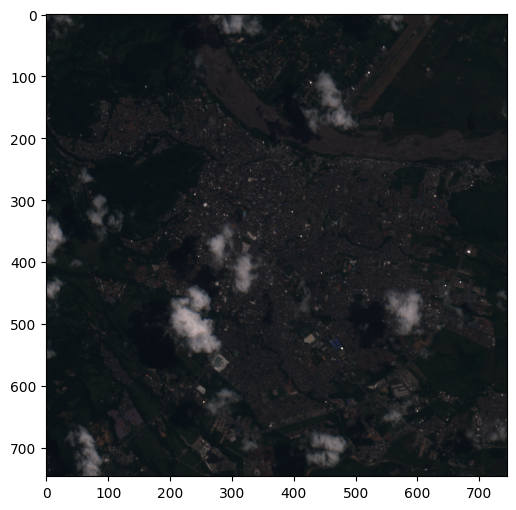

---------- Ibagué ----------
The city has 165 images
The shape of the image is: (746, 746, 12)


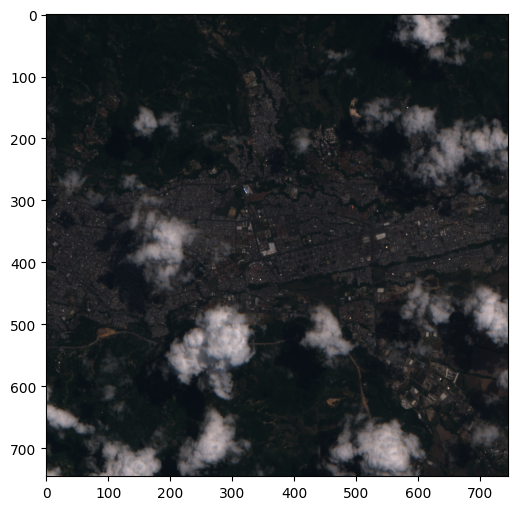

---------- Medellín ----------
The city has 165 images
The shape of the image is: (745, 747, 12)


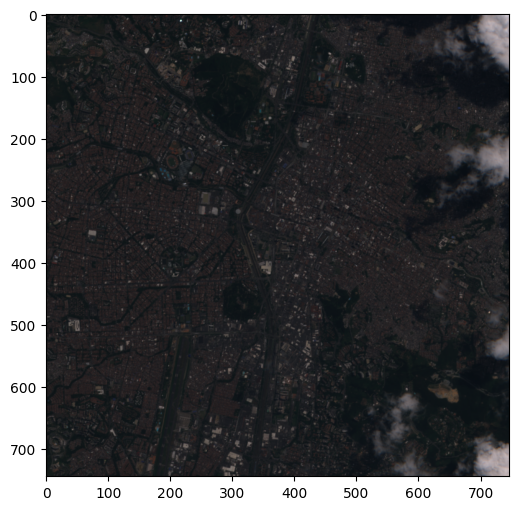

In [5]:
for city in os.listdir(path):
    images_path = os.path.join(path, city)
    print(f'---------- {city} ----------')
    print(f'The city has {len(os.listdir(images_path))} images')
    # Get the fist image
    image_path = os.path.join(images_path, os.listdir(images_path)[0])
    # read the image
    image_tiff = io.imread(image_path)
    show_image(bands, image_tiff)

## Read dataset

In [6]:
image_list = []
image_dir = {}

cities = os.listdir(path)
for city in cities:
    # Get path to city:
    images_path = os.path.join(path, city)
    image_dir[city] = os.listdir(images_path)
    for image in os.listdir(images_path):
        # make sure file is an image
        if image.endswith(('.jpg', '.png', 'jpeg', 'tiff')):
            # Get path to image:
            image_path = os.path.join(images_path, image)
            #img_path = path + file
            image_list.append(image_path)

print(f'Image list top 5 examples of length {len(image_list)}:')
#image_dir
image_list[:5]

Image list top 5 examples of length 825:


['DATASET_5_best_cities/Cali/image_2017-07-30.tiff',
 'DATASET_5_best_cities/Cali/image_2015-12-20.tiff',
 'DATASET_5_best_cities/Cali/image_2017-11-19.tiff',
 'DATASET_5_best_cities/Cali/image_2016-11-20.tiff',
 'DATASET_5_best_cities/Cali/image_2017-07-16.tiff']

# Train-Test Split

In [7]:
# Train-Test split
image_list = np.array(image_list)
x_train, x_test = train_test_split(image_list,test_size=0.2)
#x_train, x_val = train_test_split(x_train,test_size=0.1)

In [8]:
# To numpy
x_train = np.array(x_train)
#x_val = np.array(x_val)
x_test = np.array(x_test)

# Create a custom dataloader

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentation for train
train_datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True)


In [10]:
class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, image_paths,
                 batch_size,
                 input_size = (224, 224, 8),
                 shuffle = True, 
                 augmentation = None):
        
        self.image_paths = image_paths
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        self.augmentation = augmentation
        # Length of dataset
        self.n = len(self.image_paths)
        
    # Helper function to read the image
    def __get_image(self, path, target_size):
        # Read the image and convert to numpy array
        image = io.imread(path)
        # Resize the image and normalize values
        image_arr = resize(image,(target_size[0], target_size[1]))
        #print(f'The shape of the image before reshape: {image_arr.shape}, of type{type(image_arr)}')
        return image_arr
    
    def __getitem__(self, index):     
        batches = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]

        X_batch = []
        # for each image in batch
        for image_name in batches:
            # Get the image
            image = self.__get_image(image_name, self.input_size) 
            X_batch.append(image)
        
        X_batch = np.array(X_batch)
        
        # Augmentation
        if self.augmentation:
            # prepare iterator
            X_batch = self.augmentation.flow(X_batch, batch_size=self.batch_size, shuffle=True).next()
            #print('Augmentation done!')

        #print(f'The shape of the batch is : {X_batch.shape} of type: {type(X_batch)}')
        return X_batch, X_batch

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.image_paths)
            
    def __len__(self):
        return self.n // self.batch_size

In [11]:
batch_size = 16
target_size = (512, 512, 12)
traingen = CustomDataGen(x_train,
                         batch_size=batch_size, 
                         input_size=target_size, 
                         augmentation=train_datagen, 
                         shuffle = True)
                         #augmentation=None)

In [12]:
testgen = CustomDataGen(x_test,
                         batch_size=batch_size, 
                         input_size=target_size, 
                         augmentation=None)

(1, 2, 3, 512, 512, 12)
(1, 2, 3, 512, 512, 12)
(1, 2, 3, 512, 512, 12)
(1, 2, 3, 512, 512, 12)
(1, 2, 3, 512, 512, 12)
(1, 2, 3, 512, 512, 12)
(1, 2, 3, 512, 512, 12)
(1, 2, 3, 512, 512, 12)
(1, 2, 3, 512, 512, 12)


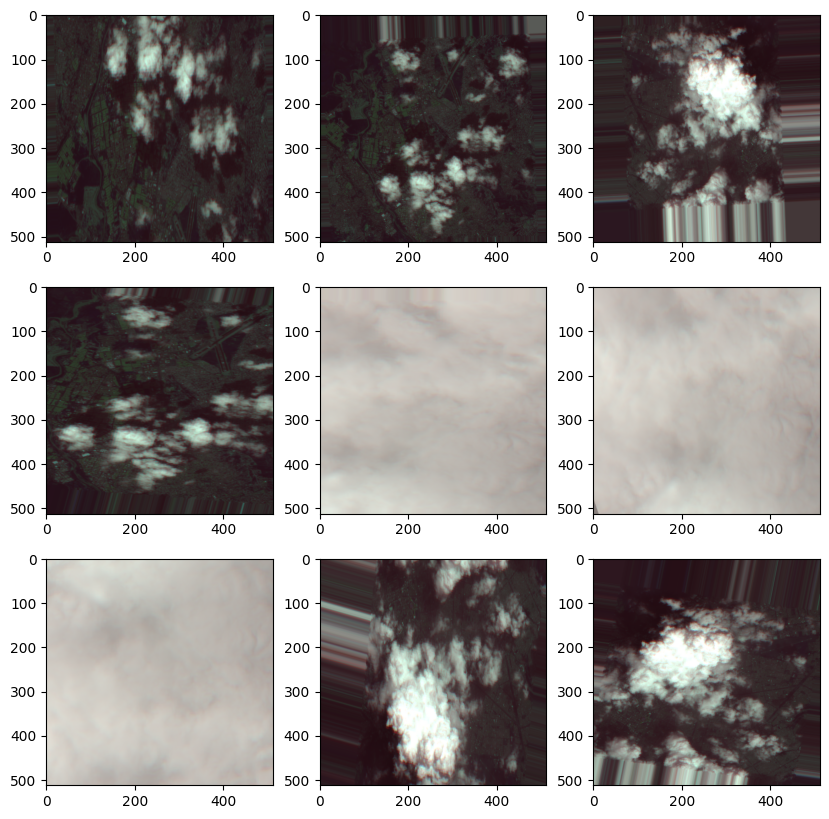

In [13]:
example_gen = CustomDataGen(x_test,
                             batch_size=9, 
                             input_size=target_size, 
                             augmentation=train_datagen, 
                             shuffle = True)
for x,y in example_gen:
    x, _ = x, y
    break

ax = plt. subplots(3, 3, figsize=(10,10))
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)

    # plot raw pixel data
    plt.imshow(x[i, :, :, 0:3])
    #plt.title(f'Image {[i]}')
    
# show the figure
plt.show()

# VAE

* https://aaltodoc.aalto.fi/bitstream/handle/123456789/38943/master_Proll_Maximilian_2019.pdf?isAllowed=y&sequence=1
* https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73
* https://keras.io/examples/generative/vae/
* https://towardsdatascience.com/variational-autoencoders-as-generative-models-with-keras-e0c79415a7eb

In [14]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape, MaxPooling2D, UpSampling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

In [15]:
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()

In [16]:
tf.random.set_seed(1234)

## Encoder Part

In [17]:
input_data = Input(shape=target_size, name='encoder_input')

# Conv block 1
encoder = Conv2D(32, 3, activation="relu", strides=2, padding="same", name="conv_1")(input_data)
encoder = BatchNormalization()(encoder)
encoder = LeakyReLU()(encoder)

# Conv block 2
encoder = Conv2D(64, 3, activation="relu", strides=2, padding="same", name="conv_2")(encoder)
encoder = BatchNormalization()(encoder)
encoder = LeakyReLU()(encoder)

# Conv block 3
encoder = Conv2D(128, 3, activation="relu", strides=2, padding="same", name="conv_3")(encoder)
encoder = BatchNormalization()(encoder)
encoder = LeakyReLU()(encoder)

conv_shape = K.int_shape(encoder) #Shape of conv to be provided to decoder

encoder = Flatten()(encoder)
encoder = Dense(1024 * 5, activation='relu')(encoder)

Instructions for updating:
Colocations handled automatically by placer.


## Latent Distribution and Sampling

In [18]:
def sample_latent_features(distribution):
    distribution_mean, distribution_variance = distribution
    batch_size = tf.shape(distribution_variance)[0]
    random = K.random_normal(shape=(batch_size, tf.shape(distribution_variance)[1]))
    return distribution_mean + tf.exp(0.5 * distribution_variance) * random

In [19]:
latent_dim = 1024 # Number of latent dim parameters

distribution_mean = Dense(latent_dim, name='mean', activation='relu')(encoder)
distribution_variance = Dense(latent_dim, name='log_variance', activation='relu')(encoder)
latent_encoding = Lambda(sample_latent_features)([distribution_mean, distribution_variance])

In [20]:
encoder_model = Model(input_data, latent_encoding)
encoder_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 512, 512, 12 0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 256, 256, 32) 3488        encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

## Decoder Part

In [21]:
decoder_input = Input(shape=(latent_dim), name='decoder_input')
decoder = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3])(decoder_input)

decoder = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(decoder)

# Transpose Conv block 1
decoder = Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same", name="deconv_1")(decoder)
decoder = BatchNormalization()(decoder)
decoder = LeakyReLU()(decoder)

# Transpose Conv block 2
decoder = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same", name="deconv_2")(decoder)
decoder = BatchNormalization()(decoder)
decoder = LeakyReLU()(decoder)

# Transpose Conv block 1
decoder = Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same", name="deconv_3")(decoder)
decoder = BatchNormalization()(decoder)
decoder = LeakyReLU()(decoder)

decoder_output = Conv2DTranspose(target_size[2], 3, activation='relu', padding="same")(decoder)

In [22]:
decoder_model = Model(decoder_input, decoder_output)
decoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 1024)]            0         
_________________________________________________________________
dense_1 (Dense)              (None, 524288)            537395200 
_________________________________________________________________
reshape (Reshape)            (None, 64, 64, 128)       0         
_________________________________________________________________
deconv_1 (Conv2DTranspose)   (None, 128, 128, 128)     147584    
_________________________________________________________________
batch_normalization_3 (Batch (None, 128, 128, 128)     512       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 128, 128, 128)     0         
_________________________________________________________________
deconv_2 (Conv2DTranspose)   (None, 256, 256, 64)      7379

## Combining

In [23]:
encoded = encoder_model(input_data)
decoded = decoder_model(encoded)

In [24]:
autoencoder = Model(input_data, decoded)

# Train model

## Loss Function (Reconstruction Loss + KL-loss)

In [25]:
def get_loss(distribution_mean, distribution_variance):
    
    def get_reconstruction_loss(y_true, y_pred):
        reconstruction_loss = keras.losses.mse(y_true, y_pred)
        reconstruction_loss_batch = tf.reduce_mean(reconstruction_loss)
        return reconstruction_loss_batch#*target_size[0]*target_size[1]
    
    def get_kl_loss(distribution_mean, distribution_variance):
        kl_loss = 1 + distribution_variance - tf.square(distribution_mean) - tf.exp(distribution_variance)
        kl_loss_batch = tf.reduce_mean(kl_loss)
        #return kl_loss_batch*(-5e-4)
        return kl_loss_batch*(-.5)
    
    def total_loss(y_true, y_pred):
        reconstruction_loss_batch = get_reconstruction_loss(y_true, y_pred)
        kl_loss_batch = get_kl_loss(distribution_mean, distribution_variance)
        #return reconstruction_loss_batch + kl_loss_batch
        return reconstruction_loss_batch + kl_loss_batch
    
    return total_loss

## Compile the model

In [26]:
adam = keras.optimizers.Adam(learning_rate=1e-4)

In [27]:
# Compile VAE
autoencoder.compile(loss=get_loss(distribution_mean, distribution_variance), optimizer='adam')
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 512, 512, 12)]    0         
_________________________________________________________________
model (Functional)           (None, 1024)              2694944224
_________________________________________________________________
model_1 (Functional)         (None, 512, 512, 12)      537639404 
Total params: 3,232,583,628
Trainable params: 3,232,582,732
Non-trainable params: 896
_________________________________________________________________


In [28]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, 
        verbose=1, mode='auto', restore_best_weights=True)

In [29]:
# fit the model
history = autoencoder.fit(traingen,
                validation_data=testgen,
                epochs=100,
                callbacks=[monitor]
)

Epoch 1/100
41/41 [==============================] - 667s 16s/step - batch: 20.0000 - size: 16.0000 - loss: 0.1330 - val_loss: 0.0843
Epoch 2/100
41/41 [==============================] - 577s 14s/step - batch: 20.0000 - size: 16.0000 - loss: 0.0527 - val_loss: 0.0573
Epoch 3/100
41/41 [==============================] - 564s 14s/step - batch: 20.0000 - size: 16.0000 - loss: 0.0514 - val_loss: 0.0537
Epoch 4/100
41/41 [==============================] - 572s 14s/step - batch: 20.0000 - size: 16.0000 - loss: 0.0490 - val_loss: 0.0495
Epoch 5/100
41/41 [==============================] - 577s 14s/step - batch: 20.0000 - size: 16.0000 - loss: 0.0472 - val_loss: 0.0453
Epoch 6/100
41/41 [==============================] - 587s 14s/step - batch: 20.0000 - size: 16.0000 - loss: 0.0468 - val_loss: 0.0426
Epoch 7/100
41/41 [==============================] - 575s 14s/step - batch: 20.0000 - size: 16.0000 - loss: 0.0446 - val_loss: 0.0423
Epoch 8/100
41/41 [==============================] - 559s 14s/

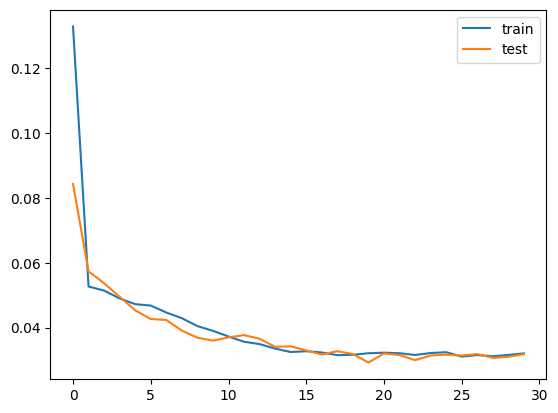

In [30]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Test Model

# Results

(1, 2, 16, 512, 512, 12)
(1, 2, 16, 512, 512, 12)
(1, 2, 16, 512, 512, 12)


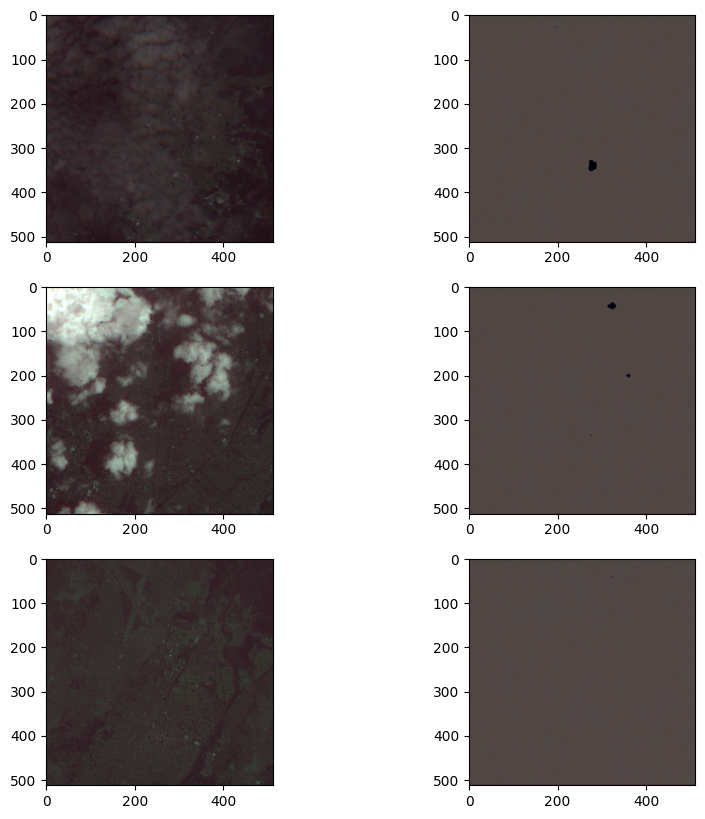

In [31]:
fig, ax = plt. subplots(3, 2, figsize=(10,10))

for i in range(3):
    # generator
    # generate batch of images
    example_batch = np.array(next(zip(testgen)))
    print(example_batch.shape)
    # Take RGB bands from first image in batch
    example_image = example_batch[0, 0, i, :, :, 0:3]
    # plot raw pixel data
    ax[i, 0].imshow(example_image)
    
    # Predicted Images
    example_image_test = example_batch[0, 0, i, :, :, :]
    example_image_test = np.expand_dims(example_image_test, axis=0)
    output = autoencoder.predict(example_image_test)
    op_image = output[0, :, :, 0:3]
    ax[i, 1].imshow(op_image)

plt.show()

# Save the model

In [ ]:
# Save the model
autoencoder.save('Models/vae_1024.h5')